In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numba import njit
from dotenv import load_dotenv
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from optimizers.simulations.order import simulate_lqe_model
from optimizers.cross_validators import vbt_cv_sliding_constructor
from optimizers.pipes.pipe import SQLPipe

load_dotenv()

USER = os.getenv('psql_username')
PASS = os.getenv('psql_password')
DATABASE = 'crypto'
SCHEMA = 'kucoin'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS)

In [2]:
assets = ['AAVE-USDT', 'CAKE-USDT']
slicer = 0 # Slice off first few months of trading to reduce early volatility

df = pipe.query_pairs_trading_backtest(assets)
closes = df.xs('close', level=1, axis=1)[slicer:]
opens = df.xs('open', level=1, axis=1)[slicer:]
assert closes.shape[0] > 8640, 'Less than 1 year of backtesting data present'
assert closes.shape == opens.shape, 'Open and close shape does not match'

print(f"Full data length: {closes.shape[0]}")

train_opens, opens = train_test_split(opens, test_size=0.30, train_size=0.70, shuffle=False)
train_closes, closes = train_test_split(closes, test_size=0.30, train_size=0.70, shuffle=False)
close_folds = vbt_cv_sliding_constructor(train_closes, n_splits=5)
open_folds = vbt_cv_sliding_constructor(train_opens, n_splits=5)

print(f"Test data length: {opens.shape[0]}")
print(f"Train fold length {close_folds[0].shape[0]}")

Full data length: 13766
Test data length: 4130
Train fold length 1927


In [3]:
from optimizers.simulations.strategies.components.models import OLS

def discretized_OU(residuals:np.array, alternative_calc:bool=False) -> float:
    """Estimate Ornstein-Uhlenbeck process from OLS residuals; return s-score"""

    Xk = residuals.cumsum()
    params = OLS(Xk[:-1], Xk[1:]) # Returns [beta, alpha]
    resids = Xk[1:] - (Xk[:-1] * params[0] + params[1])

    # kappa = -np.log(b) * (365*24) <- Kappa is unused for our purposes
    m = params[1] / (1-params[0])
    sigma_eq = np.sqrt(np.var(resids)/(1-params[0]**2))
    if alternative_calc:
        # This is purely experimental, may not be statistically valid
        s = (residuals[-1] - m) / sigma_eq
    else:
        s = -m / sigma_eq

    return s

In [4]:
from optimizers.simulations.order import simulate_rolling_ols_model
from optimizers.simulations.order import simulate_mult_rolling_ols_model

params = {
    "period": np.arange(1620, 1621, 10, dtype=int),
    "upper_entry": np.arange(1.00, 1.41, 0.05, dtype=float),
    "upper_exit": np.arange(0.75, 0.76, 0.05, dtype=float),
    "lower_entry": np.arange(1.00, 1.41, 0.05, dtype=float) * -1.0,
    "lower_exit": np.arange(0.50, 0.51, 0.05, dtype=float) * -1.0,
}

params = {
    "period": np.arange(100, 1000, 100, dtype=int),
    "upper": np.arange(2.0, 2.1, 0.10, dtype=float),
    "lower": np.arange(2.0, 2.1, 0.10, dtype=float) * -1.0,
    "exit": np.arange(0.5, 1.10, 0.10, dtype=float),
    "delta": np.array([1e-3, 1e-4, 1e-6]), 
    "vt": np.array([0.1]),
}

n = 1
for val in params.values():
    n *= len(val)
print(f'Running {n} simulations')

Running 756 simulations


In [5]:
# pf = simulate_lqe_model(
#     closes, opens,
#     transformation='log',
#     standard_score='zscore',
#     period=100,
#     upper=20.00,
#     lower=-20.00,
#     exit=0.50,
#     delta=1e-8,
#     vt=0.1,
# )

In [6]:
import numba as nb
from optimizers.simulations.strategies.components.models import OLS

@njit(parallel=True, cache=True)
def rollingOLS_nb(XX, yy, window):
    """Parallelized Numba-optimized rolling linear regression"""
    assert XX.shape == yy.shape

    params = np.full((XX.shape[0],2), np.nan, dtype=np.float_)

    for i in nb.prange(0, XX.shape[0]):
        if i > window - 2:
            window_slice = slice(max(0, i + 1 - window), i + 1)
            xvec = XX[window_slice]
            yvec = yy[window_slice]
            results = OLS(xvec, yvec)
            params[i,0:2] = results # Beta, alpha

    return params

In [32]:
@njit
def rolling_zscore_nb(XX, yy, params, window):
    assert XX.shape[0] == yy.shape[0]

    zscore = np.full(XX.shape[0], np.nan, dtype=np.float_)

    for i in nb.prange(0, XX.shape[0]):
        if i > window - 2:
            window_slice = slice(max(0, i + 1 - window), i + 1)
            xvec = XX[window_slice]
            yvec = yy[window_slice]
            beta, alpha = params[i]
            resids = yvec - (beta * xvec + alpha)
            zscore[i] = (resids[-1] - np.mean(resids)) / np.std(resids)

    return zscore

In [68]:
window = 2000
data = closes.values
XX = data[:,0]
yy = data[:,1]

params = rollingOLS_nb(XX, yy, window)
zscores = rolling_zscore_nb(XX, yy, params, window)

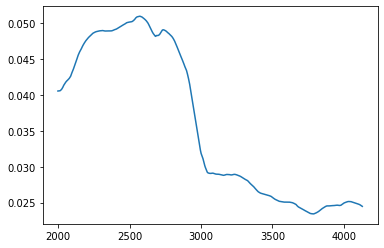

In [69]:
plt.plot(params[:,0])

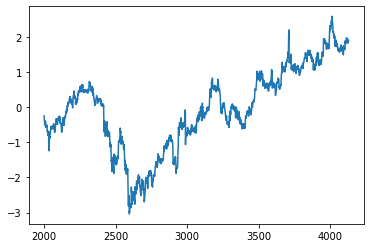

In [70]:
plt.plot(zscores)

In [20]:
zscores = np.full(XX.shape[0], np.nan, dtype=np.float_)

for i in range(0, XX.shape[0]):
    if i > window - 2:
        window_slice = slice(max(0, i + 1 - window), i + 1)
        xvec = XX[window_slice]
        yvec = yy[window_slice]
        param = params[i,:]
        resids = yvec - (param[0] * xvec + param[1])
        zscores[i] = (resids[-1] - np.mean(resids)) / np.std(resids)